Stability of defection, optimisation of strategies and the limits of memory in the PD.
----------------------

## 2. Stability of defection

In [5]:
import opt_mo

import numpy as np
import sympy as sym
import itertools
import axelrod as axl
import matplotlib.pyplot as plt

In [89]:
import matplotlib.transforms as transforms

In [6]:
import warnings; warnings.simplefilter('ignore')

In [7]:
import operator
import functools

In [8]:
sym.init_printing()

Analytical check
----------------

In [9]:
p_1, p_2, p_3, p_4 = sym.symbols("p_1, p_2, p_3, p_4")
q_1, q_2, q_3, q_4 = sym.symbols("q_1, q_2, q_3, q_4")
k_1, k_2, k_3, k_4 = sym.symbols("k_1, k_2, k_3, k_4")

p, q, k = (p_1, p_2, p_3, p_4), (q_1, q_2, q_3, q_4), (k_1, k_2, k_3, k_4)

In [10]:
utility = opt_mo.tournament_utility(p, (q, k))

In [11]:
diff_utility = [sym.diff(utility, i) for i in p]

In [12]:
diff_defector = [diff.subs({p_1:0, p_2:0, p_3:0, p_4:0}).simplify() for diff in diff_utility]

In [13]:
differences = []
for opponent in (q, k):
    rhs = opt_mo.utility.linear_term_numerator(opponent) * opt_mo.utility.constant_term_denominator(opponent)
    lhs = opt_mo.utility.linear_term_denominator(opponent) * opt_mo.utility.constant_term_numerator(opponent)
    
    product = []
    for other_opponent in (q, k):
        if opponent != other_opponent:
            product.append(opt_mo.utility.constant_term_denominator(other_opponent))

    product = functools.reduce(operator.mul, product, 1)
    differences.append((rhs - lhs) * product ** 2)
    
differences = sum(differences)

In [14]:
written_diff = [differences[i].simplify() for i in range(4)]

In [15]:
for i in range(4):
    assert (sym.fraction(diff_defector[i])[0] - written_diff[i]).simplify() == 0

Numerical check
---------------

In [16]:
def defection_stability_condition(opponents):
    differences = []
    for opponent in opponents:
        rhs = opt_mo.utility.linear_term_numerator(opponent) * opt_mo.utility.constant_term_denominator(opponent)
        lhs = opt_mo.utility.linear_term_denominator(opponent) * opt_mo.utility.constant_term_numerator(opponent)
        
        differences.append(rhs - lhs)
    total = sum(differences)
    
    return all([row <= 10 ** -8 for row in total])

In [205]:
def stackplot(plot, eco, title, logscale=True):

    populations = eco.population_sizes
    _, ax = plt.subplots()
    figure = ax.get_figure()
    turns = range(len(populations))
    pops = [
        [populations[iturn][ir] for iturn in turns]
        for ir in plot.result_set.ranking
    ]
    ax.stackplot(turns, *pops)

    ax.yaxis.tick_left()
    ax.yaxis.set_label_position("right")
    ax.yaxis.labelpad = 25.0

    ax.set_ylim([0.0, 1.0])
    ax.set_ylabel("Relative population size")
    ax.set_xlabel("Turn")
    ax.set_title(title)

    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ticks = []
    for i, n in enumerate(plot.result_set.ranked_names):
        x = -0.01
        y = (i + 0.5) * 1 / plot.result_set.num_players
        ax.annotate(
            n,
            xy=(x, y),
            xycoords=trans,
            clip_on=False,
            va="center",
            ha="right",
            fontsize=10,
        )
        ticks.append(y)
    ax.set_yticks(ticks)
    ax.tick_params(direction="out")
    ax.set_yticklabels([])
    
    if logscale:
        ax.set_xscale("log")

    plt.tight_layout()
    return figure

In [200]:
first_opponent = [1/2, 7/10, 3/5, 1/2]
second_opponent = [2/5, 3/5, 2/5, 4/5]

In [201]:
defection_stability_condition([first_opponent, second_opponent])

True

In [202]:
defection_stable_opponents_set = [axl.MemoryOnePlayer(ps) for ps in
                                  [first_opponent, second_opponent]] + [axl.Defector()]

In [203]:
tournament = axl.Tournament(defection_stable_opponents_set)
results = tournament.play(progress_bar=False)
eco = axl.Ecosystem(results)
eco.reproduce(500)

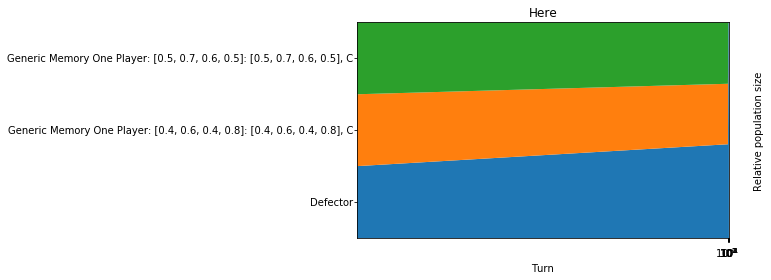

In [204]:
plot = axl.Plot(results)
p = stackplot(plot, eco, title='Here')

In [110]:
different_second_opponent = [1/4, 1/25, 13/20, 1/25]

In [111]:
defection_stability_condition([first_opponent, different_second_opponent])

False

In [112]:
defection_unstable_opponents_set = [axl.MemoryOnePlayer(ps) for ps in
                                    [first_opponent, different_second_opponent]] + [axl.Defector()]

In [113]:
tournament = axl.Tournament(defection_unstable_opponents_set)
results = tournament.play(progress_bar=False)
eco = axl.Ecosystem(results)
eco.reproduce(200)

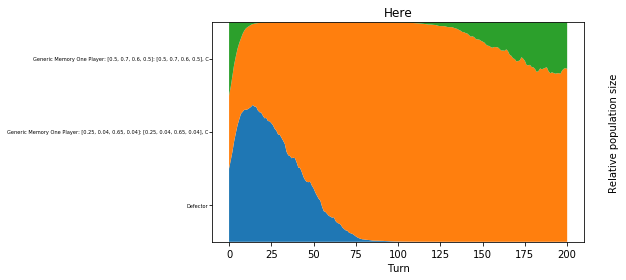

In [114]:
plot = axl.Plot(results)
p = stackplot(plot, eco, title='Here')